In [1]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import utils

In [2]:
rotations = np.array([(np.pi/2 + n*np.pi/8)%(2*np.pi) for n in range(16)])
cardinals_map = dict(zip(utils.CARDINALS, rotations))

In [3]:
cardinals_map

{'N': 1.5707963267948966,
 'NNE': 1.9634954084936207,
 'NE': 2.356194490192345,
 'ENE': 2.748893571891069,
 'E': 3.141592653589793,
 'ESE': 3.5342917352885173,
 'SE': 3.9269908169872414,
 'SSE': 4.319689898685965,
 'S': 4.71238898038469,
 'SSW': 5.105088062083414,
 'SW': 5.497787143782138,
 'WSW': 5.890486225480862,
 'W': 0.0,
 'WNW': 0.3926990816987246,
 'NW': 0.7853981633974483,
 'NNW': 1.178097245096172}

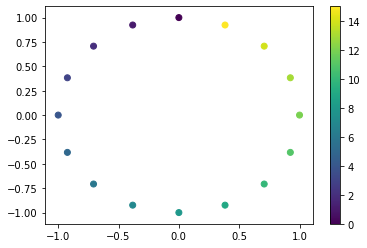

In [4]:
rotations = np.array([(np.pi/2 + n*np.pi/8)%(2*np.pi) for n in range(16)])
x = np.cos(rotations)
y = np.sin(rotations)
plt.scatter(x, y, c=list(range(len(x))))
plt.colorbar()

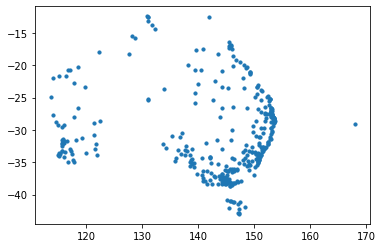

In [5]:
locations = utils.get_location_data()
plt.scatter(locations['lng'], locations['lat'], s=10)

In [6]:
def process_data(df, cardinal_map):
    if "RISK_MM" in df:
        df.drop(columns=["RISK_MM"], inplace=True)
    df.dropna(subset=["RainTomorrow"], inplace=True)
    df["Date"] = pd.to_datetime(df["Date"])
    df["Location"] = df["Location"].astype("string")
    
    df["Month_x_comp"] = np.cos(df["Date"].dt.month*np.pi/6)
    df["Month_y_comp"] = np.sin(df["Date"].dt.month*np.pi/6)
    
    for col in ("WindGustDir", "WindDir9am", "WindDir3pm"):
        df[col] = df[col].map(cardinal_map)
        df[f"{col}_x_comp"] = np.cos(df[col])
        df[f"{col}_y_comp"] = np.sin(df[col])
        df.drop(columns=[col], inplace=True)

    df["RainToday"] = df["RainToday"].map({"No": 0, "Yes": 1})
    df["RainTomorrow"] = df["RainTomorrow"].map({"No": 0, "Yes": 1})

    rain_adj_factor = (df
                       .groupby("Location")
                       .apply(lambda d: d.dropna(subset=['Rainfall'])['Date'].diff().dt.days)
                       .droplevel(0)
                       .fillna(1)
                       .rename("RainADJFactor"))
    df = df.merge(rain_adj_factor, left_index=True, right_index=True, how='left')
    df["RainADJFactor"] = df["RainADJFactor"].fillna(1)
    df["Rainfall"] = df["Rainfall"]/df["RainADJFactor"]
    df.drop(columns=["RainADJFactor"], inplace=True)

    evap_adj_factor = (df
                       .groupby("Location")
                       .apply(lambda d: d.dropna(subset=['Evaporation'])['Date'].diff().dt.days)
                       .droplevel(0)
                       .fillna(1)
                       .rename("EvapADJFactor"))
    df = df.merge(evap_adj_factor, left_index=True, right_index=True, how='left')
    df["EvapADJFactor"] = df["EvapADJFactor"].fillna(1)
    df["Evaporation"] = df["Evaporation"]/df["EvapADJFactor"]
    df.drop(columns=["EvapADJFactor"], inplace=True)

    df = df.merge(locations, how="left", left_on="Location", right_on="city").drop(columns=["city"])

    return df


def walk_forward_interpolate(s):
    for position in range(len(s)):
        if pd.isna(s.iloc[position]):
            stdev = np.random.normal(0, s.iloc[: position].std())
            s.iloc[position] = s.iloc[max(position-120, 0): position].mean() + stdev
    return s


def running_zero_count_with_reset(s):
    counter = 0
    new_series = []
    for position in range(len(s)):
        if s.iloc[position] == 0:
            counter += 1
        else:
            counter = 0
        new_series.append(counter)
    new_series = pd.Series(new_series)
    new_series.index = s.index
    return np.exp(0.01*new_series) - 1

In [7]:
df1 = pd.read_csv("weatherAUS.csv.zip")
df1 = process_data(df1, cardinals_map)
df2 = pd.read_csv("weatherAUS_second_source.csv.zip")  # from https://rdrr.io/cran/rattle.data/man/weatherAUS.html
df2 = process_data(df2, cardinals_map)
df = pd.concat([df1, df2])
del df1; del df2; gc.collect()
df.drop_duplicates(subset=["Date", "Location"], keep="first", inplace=True)
df.sort_values(by=["Date", "Location"], inplace=True, ignore_index=True)
df.drop(columns=["Date", "RainToday"], inplace=True)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205570 entries, 0 to 205569
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Location            205570 non-null  object 
 1   MinTemp             204483 non-null  float64
 2   MaxTemp             204928 non-null  float64
 3   Rainfall            203555 non-null  float64
 4   Evaporation         101671 non-null  float64
 5   Sunshine            91147 non-null   float64
 6   WindGustSpeed       191670 non-null  float64
 7   WindSpeed9am        202642 non-null  float64
 8   WindSpeed3pm        198938 non-null  float64
 9   Humidity9am         203259 non-null  float64
 10  Humidity3pm         198628 non-null  float64
 11  Pressure9am         183571 non-null  float64
 12  Pressure3pm         183603 non-null  float64
 13  Cloud9am            120568 non-null  float64
 14  Cloud3pm            113299 non-null  float64
 15  Temp9am             204373 non-nul

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0          Canberra      8.0     24.3       0.0          3.4       6.3   
1          Canberra     14.0     26.9       3.6          4.4       9.7   
2          Canberra     13.7     23.4       3.6          5.8       3.3   
3          Canberra     13.3     15.5      39.8          7.2       9.1   
4          Canberra      7.6     16.1       2.8          5.6      10.6   
...             ...      ...      ...       ...          ...       ...   
205565      Walpole     15.0     22.0       2.4          NaN       NaN   
205566     Watsonia      8.8     19.9       0.2          6.0       1.0   
205567  Williamtown     21.4     24.7       0.0          NaN       NaN   
205568  Witchcliffe     14.7     25.4       0.0          NaN       NaN   
205569      Woomera     15.2     32.5       0.0          NaN       NaN   

        WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  ...  \
0                30.0           6.0          20.0         68.0  ...   
1                39.0           4.0          17.0         80.0  ...   
2                85.0           6.0           6.0         82.0  ...   
3                54.0          30.0          24.0         62.0  ...   
4                50.0          20.0          28.0         68.0  ...   
...               ...           ...           ...          ...  ...   
205565           39.0          11.0          22.0         80.0  ...   
205566           22.0           6.0          11.0         98.0  ...   
205567           31.0          11.0          17.0         86.0  ...   
205568           48.0          24.0          30.0         60.0  ...   
205569           39.0          11.0          24.0         59.0  ...   

        Month_x_comp  Month_y_comp  WindGustDir_x_comp  WindGustDir_y_comp  \
0           0.866025     -0.500000        7.071068e-01            0.707107   
1           0.866025     -0.500000       -9.238795e-01            0.382683   
2           0.866025     -0.500000        7.071068e-01            0.707107   
3           0.866025     -0.500000        7.071068e-01            0.707107   
4           0.866025     -0.500000       -3.826834e-01           -0.923880   
...              ...           ...                 ...                 ...   
205565      0.500000      0.866025       -7.071068e-01           -0.707107   
205566      0.500000      0.866025        3.826834e-01           -0.923880   
205567      0.500000      0.866025       -9.238795e-01           -0.382683   
205568      0.500000      0.866025       -1.836970e-16           -1.000000   
205569      0.500000      0.866025        3.826834e-01           -0.923880   

        WindDir9am_x_comp  WindDir9am_y_comp  WindDir3pm_x_comp  \
0            7.071068e-01      -7.071068e-01           0.707107   
1           -1.000000e+00       1.224647e-16           1.000000   
2            6.123234e-17       1.000000e+00          -0.382683   
3            9.238795e-01       3.826834e-01           1.000000   
4           -3.826834e-01      -9.238795e-01          -0.923880   
...                   ...                ...                ...   
205565      -1.000000e+00       1.224647e-16          -0.707107   
205566      -1.836970e-16      -1.000000e+00           0.923880   
205567      -9.238795e-01       3.826834e-01          -0.923880   
205568      -9.238795e-01      -3.826834e-01          -0.382683   
205569      -7.071068e-01      -7.071068e-01           0.923880   

        WindDir3pm_y_comp      lat       lng  
0                0.707107 -35.2931  149.1269  
1                0.000000 -35.2931  149.1269  
2                0.923880 -35.2931  149.1269  
3                0.000000 -35.2931  149.1269  
4               -0.382683 -35.2931  149.1269  
...                   ...      ...       ...  
205565          -0.707107 -34.9777  116.7338  
205566          -0.382683 -37.7080  145.0830  
205567           0.382683 -32.8150  151.8428  
205568          -0.923880 -34.0261  115.1003  
205569    

In [8]:
df.describe().T

count         mean        std       min          25%  \
MinTemp             204483.0    12.163906   6.455025   -8.7000     7.500000   
MaxTemp             204928.0    23.352364   7.201863   -4.8000    18.000000   
Rainfall            203555.0     2.201064   8.054989    0.0000     0.000000   
Evaporation         101671.0     5.259083   3.435464    0.0000     2.600000   
Sunshine             91147.0     7.666357   3.767291    0.0000     4.900000   
WindGustSpeed       191670.0    40.154656  13.591801    2.0000    31.000000   
WindSpeed9am        202642.0    14.056864   8.888583    0.0000     7.000000   
WindSpeed3pm        198938.0    18.697182   8.753714    0.0000    13.000000   
Humidity9am         203259.0    68.432935  19.434777    0.0000    56.000000   
Humidity3pm         198628.0    50.908004  21.035469    0.0000    35.000000   
Pressure9am         183571.0  1017.649490   7.075773  979.1000  1012.900000   
Pressure3pm         183603.0  1015.234487   7.013484  977.1000  1010.400000   
Cloud9am            120568.0     4.593358   2.897947    0.0000     1.000000   
Cloud3pm            113299.0     4.598734   2.753125    0.0000     2.000000   
Temp9am             204373.0    17.019797   6.563083   -7.2000    12.300000   
Temp3pm             199737.0    21.795275   7.039178   -5.4000    16.700000   
RainTomorrow        205570.0     0.218091   0.412951    0.0000     0.000000   
Month_x_comp        205570.0     0.002642   0.709172   -1.0000    -0.866025   
Month_y_comp        205570.0    -0.010898   0.704950   -1.0000    -0.866025   
WindGustDir_x_comp  191573.0     0.024934   0.712752   -1.0000    -0.707107   
WindGustDir_y_comp  191573.0    -0.044634   0.699554   -1.0000    -0.707107   
WindDir9am_x_comp   190565.0    -0.020167   0.694561   -1.0000    -0.707107   
WindDir9am_y_comp   190565.0     0.012059   0.719054   -1.0000    -0.707107   
WindDir3pm_x_comp   197577.0     0.025861   0.712538   -1.0000    -0.707107   
WindDir3pm_y_comp   197577.0    -0.039428   0.700051   -1.0000    -0.707107   
lat                 205570.0   -32.775245   5.987126  -42.8806   -36.080600   
lng                 205570.0   142.079228  12.053570  115.1003   138.601100   

                             50%          75%        max  
MinTemp             1.200000e+01    16.900000    33.9000  
MaxTemp             2.280000e+01    28.400000    48.9000  
Rainfall            0.000000e+00     0.600000   371.0000  
Evaporation         4.600000e+00     7.200000   133.9000  
Sunshine            8.500000e+00    10.700000    14.5000  
WindGustSpeed       3.900000e+01    48.000000   135.0000  
WindSpeed9am        1.300000e+01    19.000000   130.0000  
WindSpeed3pm        1.900000e+01    24.000000    87.0000  
Humidity9am         6.900000e+01    83.000000   100.0000  
Humidity3pm         5.100000e+01    65.000000   100.0000  
Pressure9am         1.017600e+03  1022.400000  1041.1000  
Pressure3pm         1.015200e+03  1020.000000  1040.1000  
Cloud9am            5.000000e+00     7.000000     9.0000  
Cloud3pm            5.000000e+00     7.000000     9.0000  
Temp9am             1.680000e+01    21.600000    40.2000  
Temp3pm             2.120000e+01    26.600000    48.2000  
RainTomorrow        0.000000e+00     0.000000     1.0000  
Month_x_comp        6.123234e-17     0.866025     1.0000  
Month_y_comp       -2.449294e-16     0.500000     1.0000  
WindGustDir_x_comp  6.123234e-17     0.707107     1.0000  
WindGustDir_y_comp  0.000000e+00     0.707107     1.0000  
WindDir9am_x_comp  -1.836970e-16     0.707107     1.0000  
WindDir9am_y_comp   1.224647e-16     0.707107     1.0000  
WindDir3pm_x_comp   6.123234e-17     0.707107     1.0000  
WindDir3pm_y_comp   0.000000e+00     0.707107     1.0000  
lat                -3.393990e+01   -31.495800   -12.4381  
lng                 1.458389e+02   150.751100   167.9547

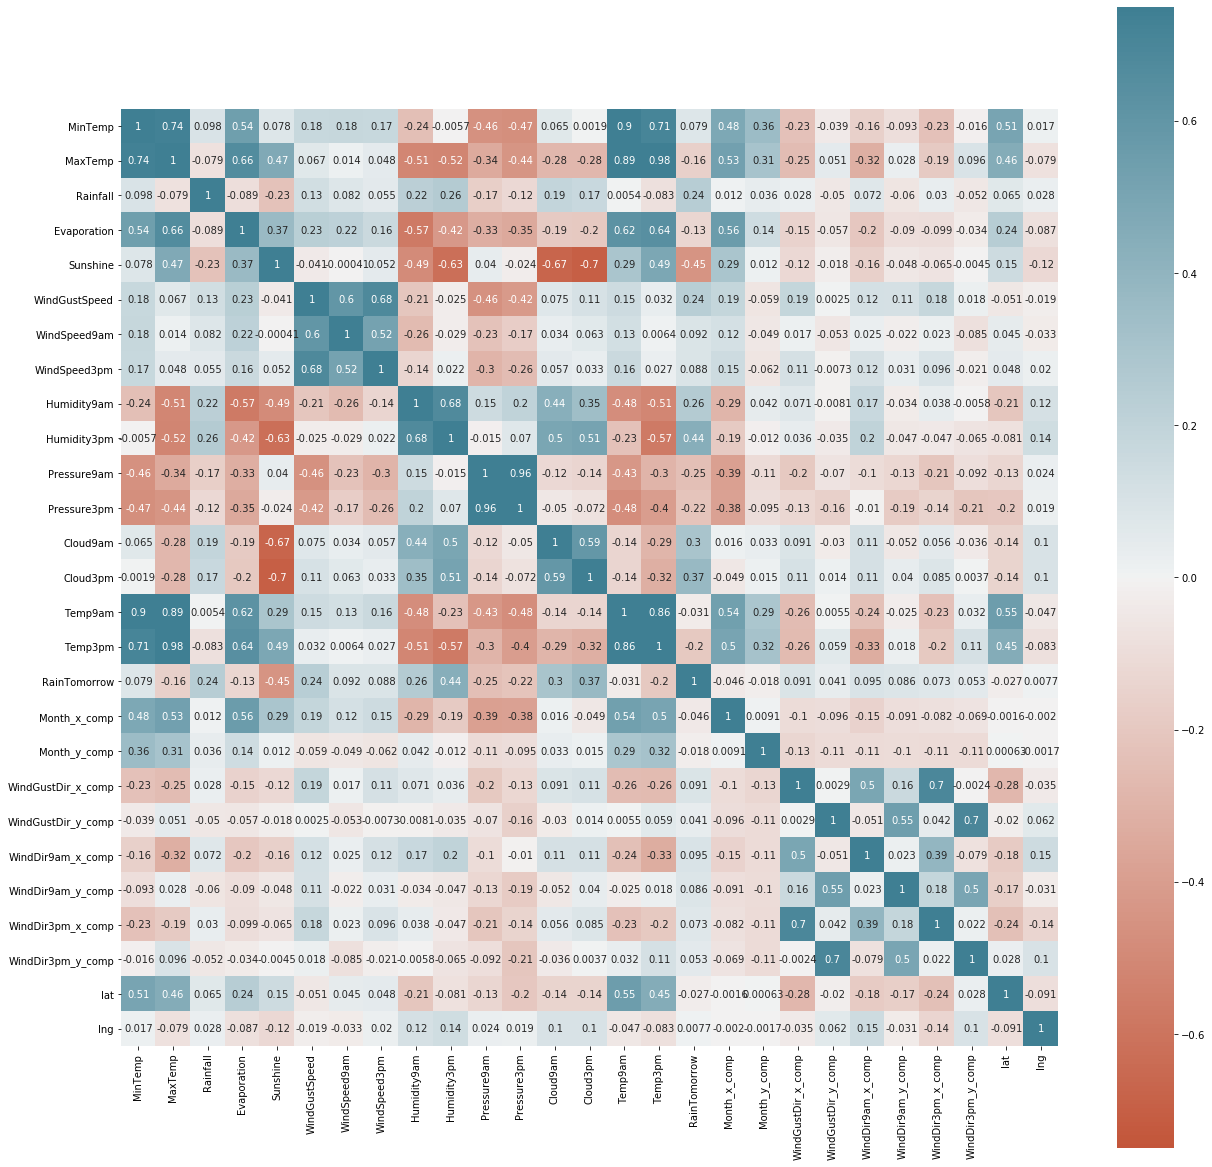

In [9]:
plt.figure(figsize=(21, 21))
sns.heatmap(df.corr(), square=True, annot=True, fmt='.2g',
            cmap=sns.diverging_palette(20, 220, n=256, as_cmap=True),
            vmin=-0.75, vmax=0.75)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["RainTomorrow"]), df["RainTomorrow"], test_size=0.25, shuffle=False
)

In [11]:
del df; gc.collect()

59

In [12]:
X_train["Evaporation"] = X_train.groupby("Location")["Evaporation"].apply(lambda s: walk_forward_interpolate(s)).clip(0, 100)
X_train["Sunshine"] = X_train.groupby("Location")["Sunshine"].apply(lambda s: walk_forward_interpolate(s)).clip(0, 25)
X_train["Cloud9am"] = X_train.groupby("Location")["Cloud9am"].apply(lambda s: walk_forward_interpolate(s)).clip(0, 9)
X_train["Cloud3pm"] = X_train.groupby("Location")["Cloud3pm"].apply(lambda s: walk_forward_interpolate(s)).clip(0, 9)

X_test["Evaporation"] = X_test.groupby("Location")["Evaporation"].apply(lambda s: walk_forward_interpolate(s)).clip(0, 100)
X_test["Sunshine"] = X_test.groupby("Location")["Sunshine"].apply(lambda s: walk_forward_interpolate(s)).clip(0, 25)
X_test["Cloud9am"] = X_test.groupby("Location")["Cloud9am"].apply(lambda s: walk_forward_interpolate(s)).clip(0, 9)
X_test["Cloud3pm"] = X_test.groupby("Location")["Cloud3pm"].apply(lambda s: walk_forward_interpolate(s)).clip(0, 9)

X_train.update(X_train.groupby("Location").ffill())
X_test.update(X_test.groupby("Location").ffill())

dry_reads = X_train.groupby("Location")["Rainfall"].apply(running_zero_count_with_reset).rename("RunningDryReads")
X_train = X_train.merge(dry_reads, left_index=True, right_index=True)

dry_reads = X_test.groupby("Location")["Rainfall"].apply(running_zero_count_with_reset).rename("RunningDryReads")
X_test = X_test.merge(dry_reads, left_index=True, right_index=True)

for col in X_train:
    X_train[col] = X_train[col].fillna(utils.DEFAULT_VALS.get(col, np.nan))

for col in X_test:
    X_test[col] = X_test[col].fillna(utils.DEFAULT_VALS.get(col, np.nan))

cols_to_lag = ["Temp9am", "Temp3pm", "Humidity9am", "Humidity3pm",
               "Pressure9am", "Pressure3pm", "FEAT1", "FEAT2", "FEAT3", "FEAT4"]

X_train = utils.feature_transformer(X_train)
X_test = utils.feature_transformer(X_test)

shifted = X_train.groupby("Location")[cols_to_lag].shift(1)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG1")
X_train = X_train.merge(shifted, left_index=True, right_index=True)

shifted = X_test.groupby("Location")[cols_to_lag].shift(1)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG1")
X_test = X_test.merge(shifted, left_index=True, right_index=True)

shifted = X_train.groupby("Location")[cols_to_lag].shift(2)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG2")
X_train = X_train.merge(shifted, left_index=True, right_index=True)

shifted = X_test.groupby("Location")[cols_to_lag].shift(2)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG2")
X_test = X_test.merge(shifted, left_index=True, right_index=True)

for col in cols_to_lag:
    X_train[f"{col}_LAG1"] = X_train[f"{col}_LAG1"].fillna(utils.DEFAULT_VALS.get(col, np.nan))
    X_train[f"{col}_LAG2"] = X_train[f"{col}_LAG2"].fillna(utils.DEFAULT_VALS.get(col, np.nan))
    X_test[f"{col}_LAG1"] = X_test[f"{col}_LAG1"].fillna(utils.DEFAULT_VALS.get(col, np.nan))
    X_test[f"{col}_LAG2"] = X_test[f"{col}_LAG2"].fillna(utils.DEFAULT_VALS.get(col, np.nan))
    
X_train.drop(columns=["WindDir9am_x_comp", "WindDir9am_y_comp",
                      "WindDir3pm_x_comp", "WindDir3pm_y_comp",
                      "WindGustDir_x_comp", "WindGustDir_y_comp"], inplace=True)

X_test.drop(columns=["WindDir9am_x_comp", "WindDir9am_y_comp",
                     "WindDir3pm_x_comp", "WindDir3pm_y_comp",
                     "WindGustDir_x_comp", "WindGustDir_y_comp"], inplace=True)

X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154177 entries, 0 to 154176
Data columns (total 58 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Location          154177 non-null  object 
 1   MinTemp           154177 non-null  float64
 2   MaxTemp           154177 non-null  float64
 3   Rainfall          154177 non-null  float64
 4   Evaporation       154177 non-null  float64
 5   Sunshine          154177 non-null  float64
 6   WindGustSpeed     154177 non-null  float64
 7   WindSpeed9am      154177 non-null  float64
 8   WindSpeed3pm      154177 non-null  float64
 9   Humidity9am       154177 non-null  float64
 10  Humidity3pm       154177 non-null  float64
 11  Pressure9am       154177 non-null  float64
 12  Pressure3pm       154177 non-null  float64
 13  Cloud9am          154177 non-null  float64
 14  Cloud3pm          154177 non-null  float64
 15  Temp9am           154177 non-null  float64
 16  Temp3pm           15

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0  Canberra      8.0     24.3       0.0          3.4       6.3           30.0   
1  Canberra     14.0     26.9       3.6          4.4       9.7           39.0   
2  Canberra     13.7     23.4       3.6          5.8       3.3           85.0   
3  Canberra     13.3     15.5      39.8          7.2       9.1           54.0   
4  Canberra      7.6     16.1       2.8          5.6      10.6           50.0   

   WindSpeed9am  WindSpeed3pm  Humidity9am  ...  Temp9am_LAG2  Temp3pm_LAG2  \
0           6.0          20.0         68.0  ...          15.0          20.0   
1           4.0          17.0         80.0  ...          15.0          20.0   
2           6.0           6.0         82.0  ...          14.4          23.6   
3          30.0          24.0         62.0  ...          17.5          25.7   
4          20.0          28.0         68.0  ...          15.4          20.2   

   Humidity9am_LAG2  Humidity3pm_LAG2  Pressure9am_LAG2  Pressure3pm_LAG2  \
0              70.0              60.0            1015.0            1015.0   
1              70.0              60.0            1015.0            1015.0   
2              68.0              29.0            1019.7            1015.0   
3              80.0              36.0            1012.4            1008.4   
4              82.0              69.0            1009.5            1007.2   

   FEAT1_LAG2  FEAT2_LAG2  FEAT3_LAG2  FEAT4_LAG2  
0         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN  
2        16.3    0.392638    0.957055        -4.7  
3        12.9    0.271318    0.906977        -4.0  
4         9.7    0.175258    0.670103        -2.3  

[5 rows x 58 columns]

In [13]:
X_train.describe().T

count         mean        std         min          25%  \
MinTemp           154177.0    12.197779   6.429521   -8.700000     7.600000   
MaxTemp           154177.0    23.338694   7.165946   -4.800000    18.000000   
Rainfall          154177.0     2.274897   8.215488   -1.000000     0.000000   
Evaporation       154177.0     3.136023   3.982725   -1.000000    -1.000000   
Sunshine          154177.0     4.443654   5.157500   -1.000000    -1.000000   
WindGustSpeed     154177.0    40.140151  13.225936    2.000000    31.000000   
WindSpeed9am      154177.0    14.055547   8.882474    0.000000     7.000000   
WindSpeed3pm      154177.0    18.948352   9.105402    0.000000    13.000000   
Humidity9am       154177.0    68.617401  19.292303    0.000000    57.000000   
Humidity3pm       154177.0    51.078987  20.946710    0.000000    36.000000   
Pressure9am       154177.0  1017.276638   6.785861  980.500000  1013.300000   
Pressure3pm       154177.0  1015.103627   6.679284  977.100000  1010.900000   
Cloud9am          154177.0     4.450033   2.462458    0.000000     3.000000   
Cloud3pm          154177.0     4.419705   2.348585    0.000000     3.000000   
Temp9am           154177.0    17.024294   6.555533   -7.200000    12.300000   
Temp3pm           154177.0    21.768674   7.008885   -5.400000    16.600000   
Month_x_comp      154177.0     0.004942   0.709456   -1.000000    -0.866025   
Month_y_comp      154177.0    -0.012947   0.704618   -1.000000    -0.866025   
lat               154177.0   -32.740549   6.046274  -42.880600   -36.080600   
lng               154177.0   142.070761  12.066786  115.100300   138.601100   
RunningDryReads   154177.0     0.058051   0.185267    0.000000     0.000000   
FEAT1             154177.0    11.140915   4.946141    0.100000     7.300000   
FEAT2             154177.0     0.431440   0.173145    0.000000     0.312500   
FEAT3             154177.0     0.822808   0.179078    0.000000     0.781818   
FEAT4             154177.0    -2.173011   2.026594  -19.200000    -3.600000   
FEAT5             154177.0   -17.538414  16.635224  -91.000000   -29.000000   
FEAT6             154177.0     8.455521  12.507514    0.539824     0.905863   
FEAT7             154177.0    25.858665  38.235876  -31.000000     1.000000   
FEAT8             154177.0    -1.306436  34.566305 -135.000000   -26.000000   
FEAT9             154177.0    -5.628831  33.292234 -135.000000   -28.991378   
FEAT10            154177.0    -0.075741  11.425308  -66.519326    -7.270985   
FEAT11            154177.0     1.061428  15.021971  -61.518290   -10.162675   
FEAT12            154177.0     0.099320  12.079668  -87.000000    -7.270985   
FEAT13            154177.0    -1.240393  14.616411  -74.000000   -12.010434   
FEAT14            154177.0     9.605539   3.664813    0.000000     6.992521   
FEAT15            154177.0     0.745050   5.533292  -21.719818    -0.584906   
FEAT16            154177.0     9.282728   5.720187   -2.160000     5.280000   
Temp9am_LAG1      154177.0    17.022422   6.554778   -7.200000    12.300000   
Temp3pm_LAG1      154177.0    21.766797   7.007981   -5.400000    16.600000   
Humidity9am_LAG1  154177.0    68.618121  19.289879    0.000000    57.000000   
Humidity3pm_LAG1  154177.0    51.082769  20.944110    0.000000    36.000000   
Pressure9am_LAG1  154177.0  1017.277290   6.785272  980.500000  1013.300000   
Pressure3pm_LAG1  154177.0  1015.104670   6.678613  977.100000  1010.900000   
FEAT1_LAG1        154128.0    11.140950   4.946279    0.100000     7.300000   
FEAT2_LAG1        154128.0     0.431458   0.173137    0.000000     0.312500   
FEAT3_LAG1        154128.0     0.822817   0.179079    0.000000     0.781818   
FEAT4_LAG1        154128.0    -2.173311   2.026662  -19.200000    -3.600000   
Temp9am_LAG2      154177.0    17.020510   6.554124   -7.200000    12.300000   
Temp3pm_LAG2      154177.0    21.764504   7.006768   -5.400000    16.600000   
Humidity9am_LAG2  154177.0    68.619891  19.287092    0.000000    57.00

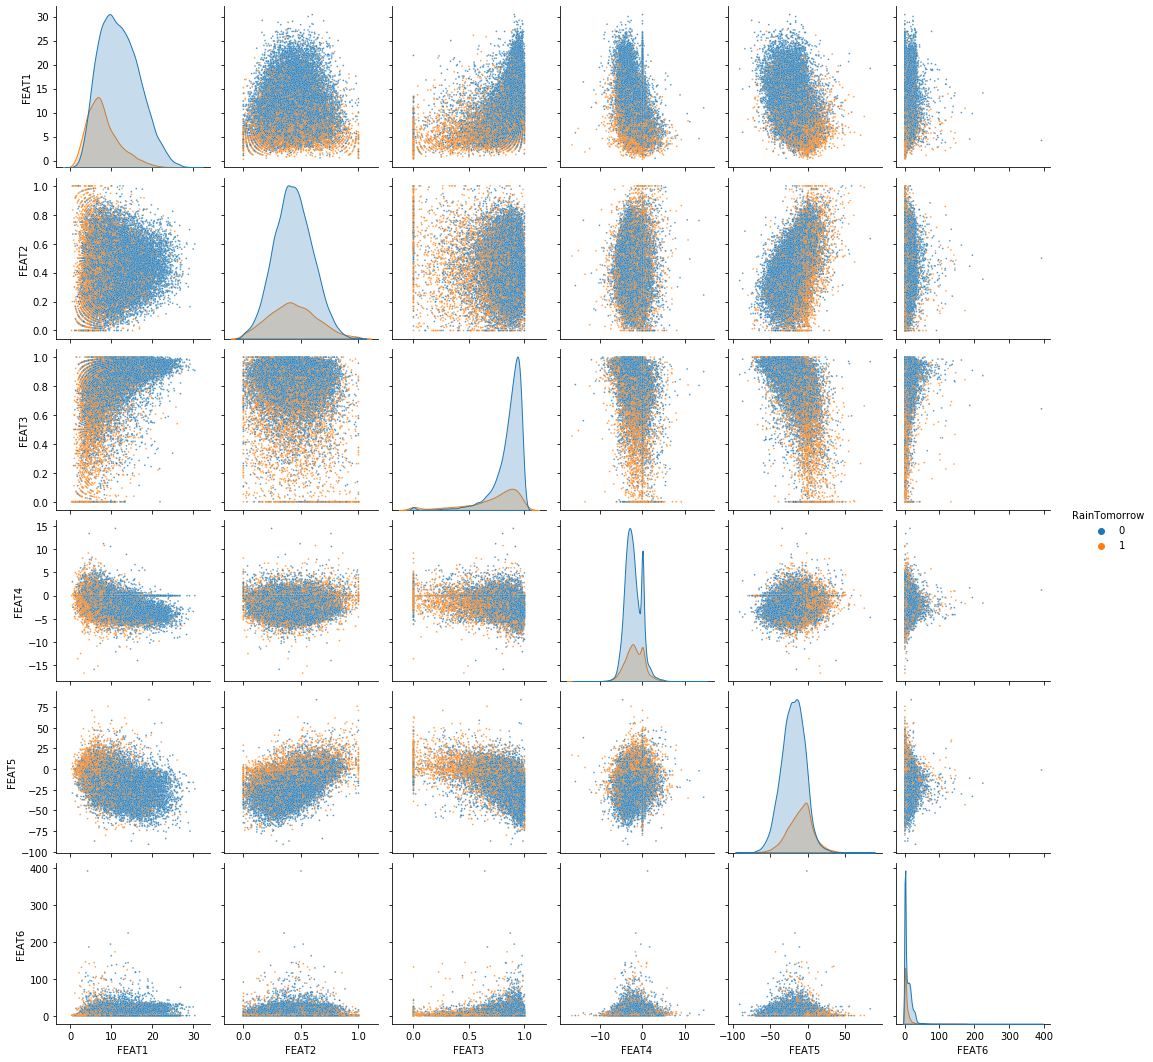

In [14]:
sns.pairplot(X_train.merge(y_train, left_index=True, right_index=True)[[col for col in X_train if "FEAT" in col][:6] + ["RainTomorrow"]].sample(25000),
             hue="RainTomorrow",
             plot_kws={"alpha": 0.75, "s": 3})

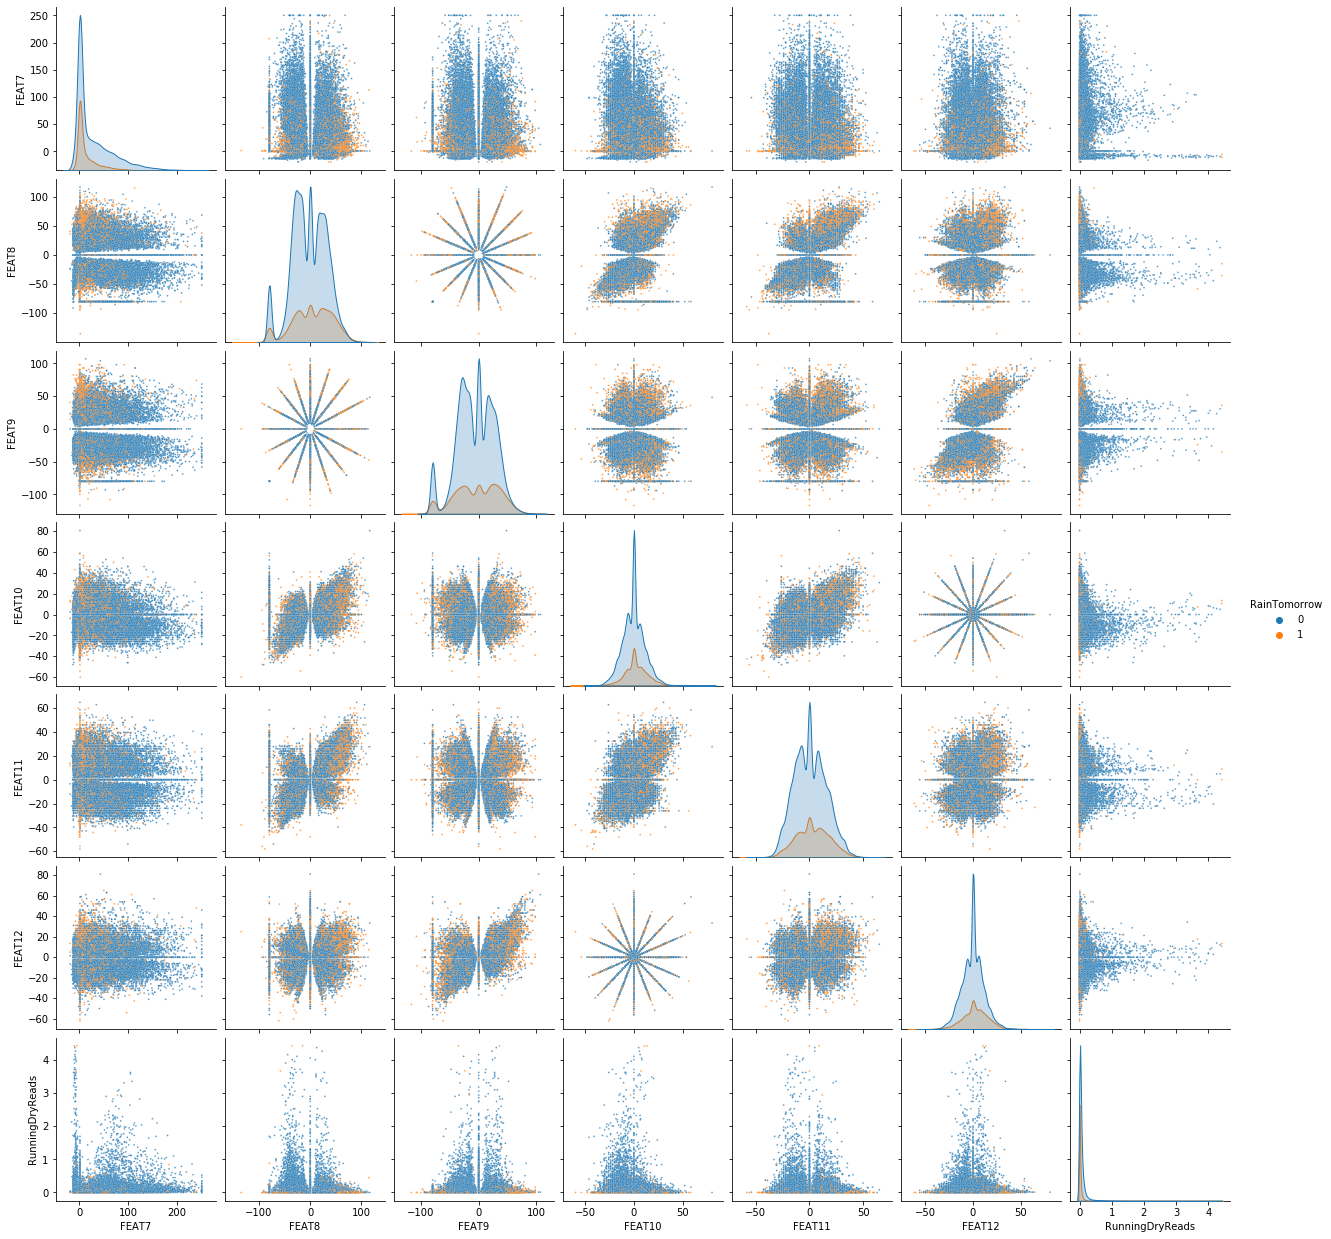

In [15]:
sns.pairplot(X_train.merge(y_train,
                           left_index=True,
                           right_index=True)[[col for col in X_train if "FEAT" in col][6:12] + ["RainTomorrow"] + ["RunningDryReads"]].sample(50000),
             hue="RainTomorrow",
             plot_kws={"alpha": 0.75, "s": 3})

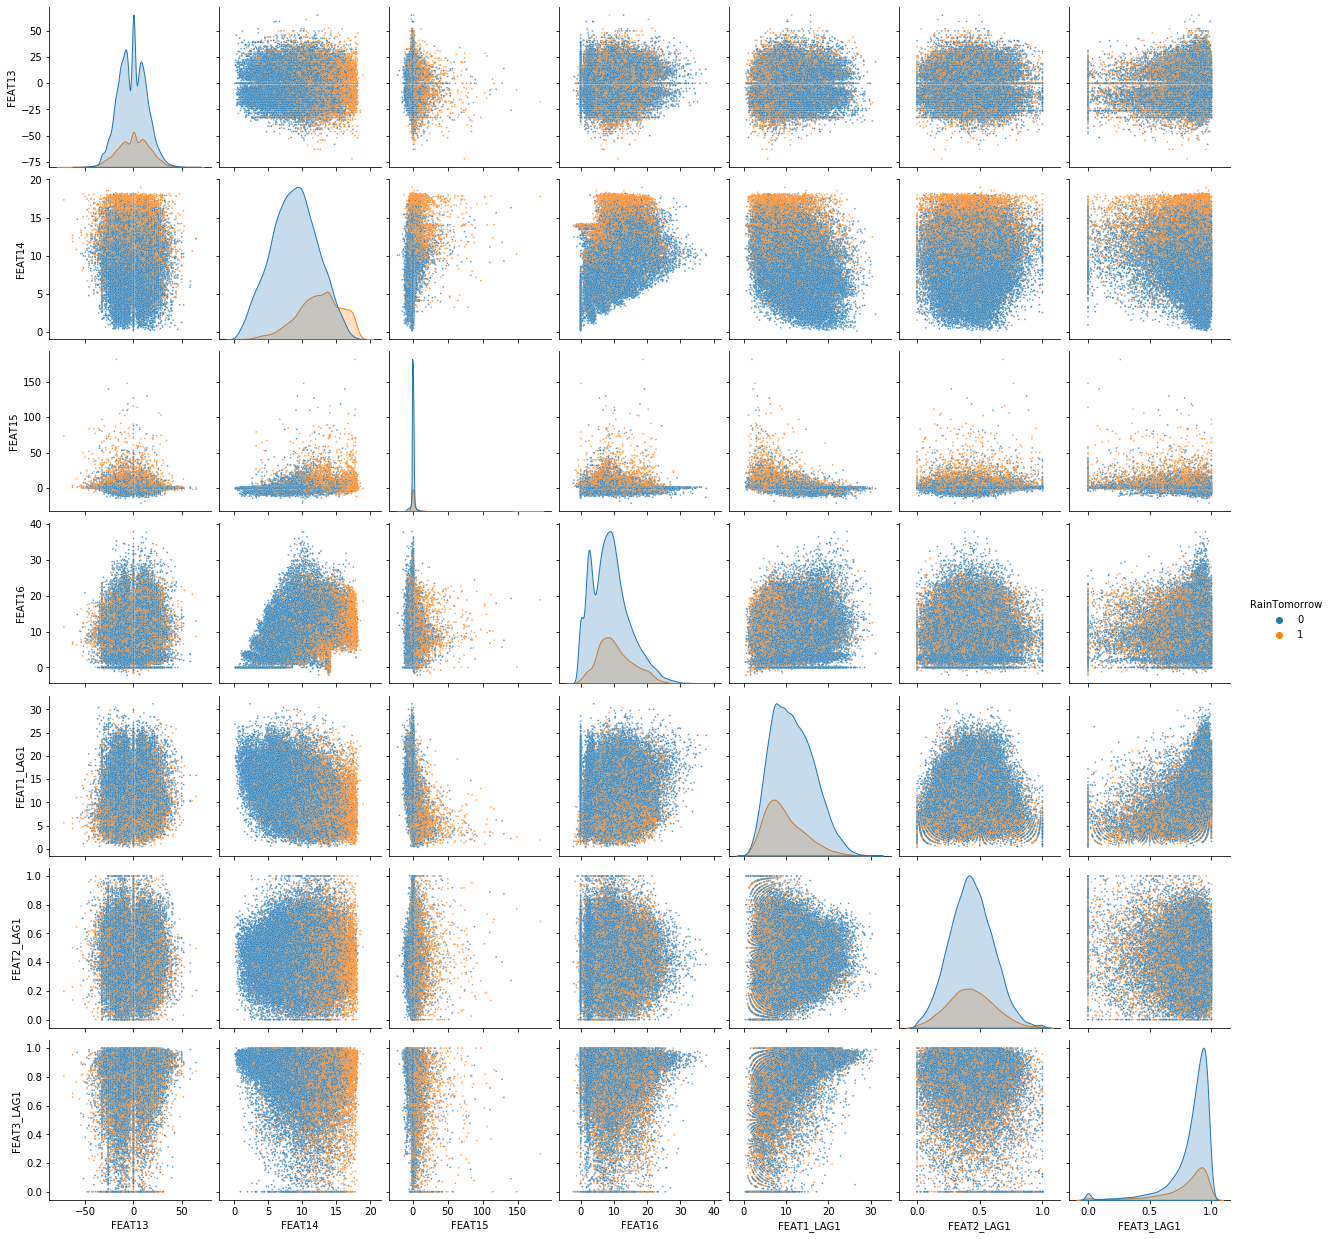

In [16]:
sns.pairplot(X_train.merge(y_train, left_index=True, right_index=True)[[col for col in X_train if "FEAT" in col][12:19] + ["RainTomorrow"]].sample(50000),
             hue="RainTomorrow",
             plot_kws={"alpha": 0.75, "s": 3})

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154177 entries, 0 to 154176
Data columns (total 58 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Location          154177 non-null  object 
 1   MinTemp           154177 non-null  float64
 2   MaxTemp           154177 non-null  float64
 3   Rainfall          154177 non-null  float64
 4   Evaporation       154177 non-null  float64
 5   Sunshine          154177 non-null  float64
 6   WindGustSpeed     154177 non-null  float64
 7   WindSpeed9am      154177 non-null  float64
 8   WindSpeed3pm      154177 non-null  float64
 9   Humidity9am       154177 non-null  float64
 10  Humidity3pm       154177 non-null  float64
 11  Pressure9am       154177 non-null  float64
 12  Pressure3pm       154177 non-null  float64
 13  Cloud9am          154177 non-null  float64
 14  Cloud3pm          154177 non-null  float64
 15  Temp9am           154177 non-null  float64
 16  Temp3pm           15

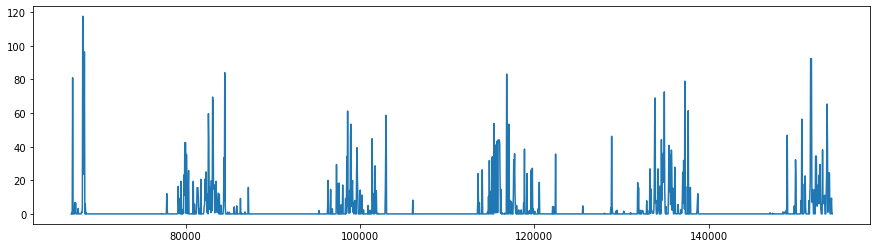

In [18]:
X_train[X_train['Location'] == "Katherine"]["Rainfall"].plot(figsize=(15, 4))

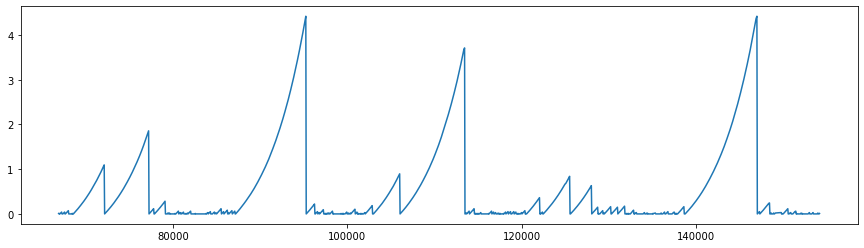

In [19]:
X_train[X_train['Location'] == "Katherine"]["RunningDryReads"].plot(figsize=(15, 4))

In [20]:
param_distribs = {
    "n_estimators": [250, 300, 350, 400, 450, 500, 550, 600],
    "max_depth": [6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
    "num_leaves": [25, 30, 35, 40, 45, 50, 55, 60],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "reg_lambda": [0, 0.5, 1, 5, 10, 25, 50, 75, 100, 150, 200]
}

clf = lgb.LGBMClassifier(n_jobs=-1, random_state=0, silent=False)
ts_cv = TimeSeriesSplit(n_splits=4)
searcher = RandomizedSearchCV(
    clf,
    param_distributions=param_distribs,
    n_iter=75,
    scoring="balanced_accuracy",
    n_jobs=-1,
    cv=ts_cv,
    random_state=0
)
searcher.fit(X_train.drop(columns=["Location"]), y_train)

[LightGBM] [Info] Number of positive: 34365, number of negative: 119812
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11896
[LightGBM] [Info] Number of data points in the train set: 154177, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222893 -> initscore=-1.248885
[LightGBM] [Info] Start training from score -1.248885


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=LGBMClassifier(random_state=0, silent=False),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'max_depth': [6, 8, 10, 12, 14, 16, 18,
                                                      20, 22, 24],
                                        'n_estimators': [250, 300, 350, 400,
                                                         450, 500, 550, 600],
                                        'num_leaves': [25, 30, 35, 40, 45, 50,
                                                       55, 60],
                                        'reg_lambda': [0, 0.5, 1, 5, 10, 25, 50,
                                                       75, 100, 150, 200],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]},
                   random_state=0, scoring='balanc

In [21]:
pd.DataFrame(searcher.cv_results_).drop(columns=['params']).sort_values(by="rank_test_score").head(25)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
60      34.141947     11.985463         3.798081        0.014453   
13      26.985528      8.170020         3.235357        0.039228   
36      19.720949      6.269392         2.400179        0.017014   
59      22.437220      7.589438         2.565756        0.067828   
37      28.157404      9.236078         3.462144        0.056926   
47      34.674290     11.334580         4.552660        0.120432   
71      21.688707      7.538993         2.436455        0.332996   
29      19.425417      5.660888         2.553159        0.142128   
34      23.330670      6.801220         3.241258        0.155333   
12      22.749455      7.407858         2.711117        0.144330   
40      19.674203      7.410611         2.610620        0.156620   
38      18.524871      5.840256         2.257675        0.010082   
7       18.377206      5.819865         2.488588        0.048035   
70      15.616606      5.316581         1.889301        0.043537   
30      28.396715      8.428340         3.552523        0.054178   
28      31.918807     11.092935         3.656953        0.058060   
9       23.129716      8.885524         2.568809        0.056468   
22      24.240263      7.281337         3.113477        0.056551   
18      17.622875      5.309891         2.280922        0.030934   
56      30.080723     10.312917         3.900825        0.114574   
27      16.327739      5.149818         2.056257        0.014429   
43      22.589913      4.871412         2.842487        0.091231   
46      20.333756      7.119718         2.505239        0.009246   
8       20.540804      7.826992         2.328942        0.059044   
48      19.369287      5.583410         2.159385        0.177703   

   param_subsample param_reg_lambda param_num_leaves param_n_estimators  \
60             0.7              200               55                550   
13             0.7              200               50                500   
36             0.6              150               30                450   
59               1              200               45                400   
37             0.7              150               45                550   
47             0.5              150               60                600   
71             0.9              100               40                450   
29             0.6               75               40                450   
34             0.8              100               35                600   
12               1               50               60                400   
40               1               50               30                550   
38             0.9              200               35                400   
7              0.9              100               30                500   
70               1              100               50                300   
30             0.6              200               40                600   
28             0.8              150               50                550   
9              0.9              200               50                400   
22               1              200               30                600   
18             0.8              150               25                500   
56             0.8               75               60                550   
27             0.5              150               50                450   
43             0.6               75               50                450   
46             0.7              200               50                550   
8              0.7               75               55                350   
48               1               25               55                350   

   param_max_depth  split0_test_score  split1_test_score  split2_test_score  \
60              12           0.756307           0.763764           0.736008   
13              16           0.756802           0.762773           0.736259   
36              14           0.758344          

In [22]:
graph = lgb.create_tree_digraph(searcher.best_estimator_)
graph.render(filename="more_feature_eng")

'more_feature_eng.pdf'

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     40925
           1       0.75      0.57      0.64     10468

    accuracy                           0.87     51393
   macro avg       0.82      0.76      0.78     51393
weighted avg       0.87      0.87      0.87     51393



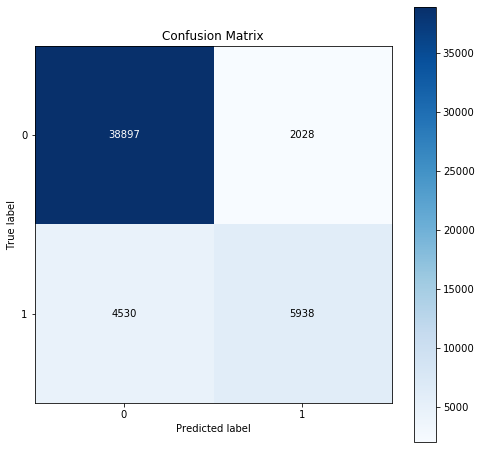

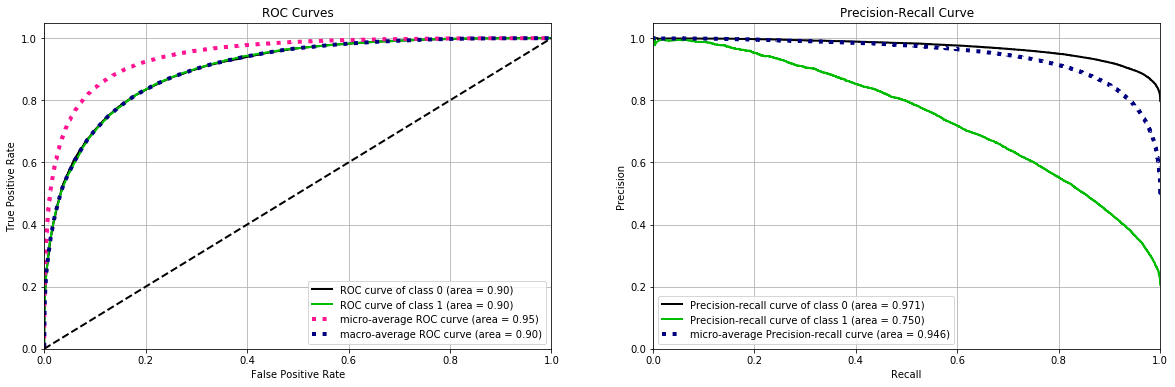

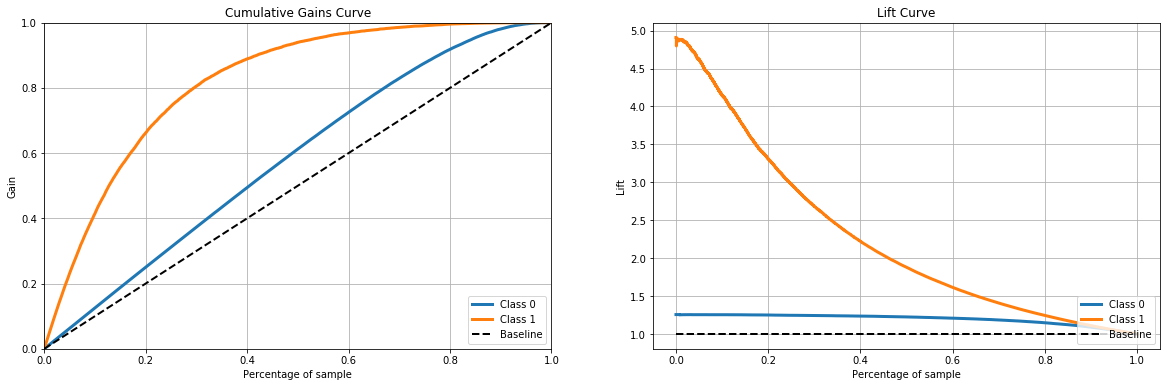

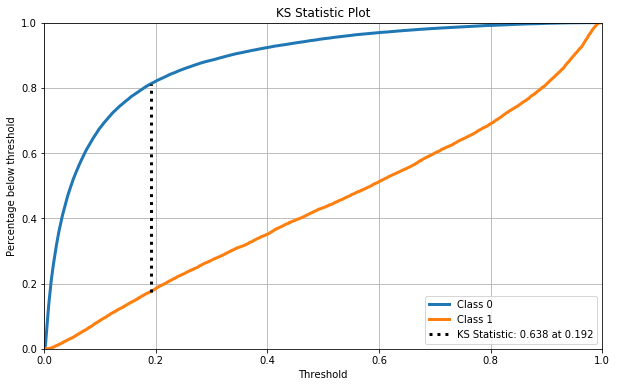

In [23]:
utils.evaluate_binary_clf(
    X_test.drop(columns=["Location"]),
    y_test,
    searcher.best_estimator_
)

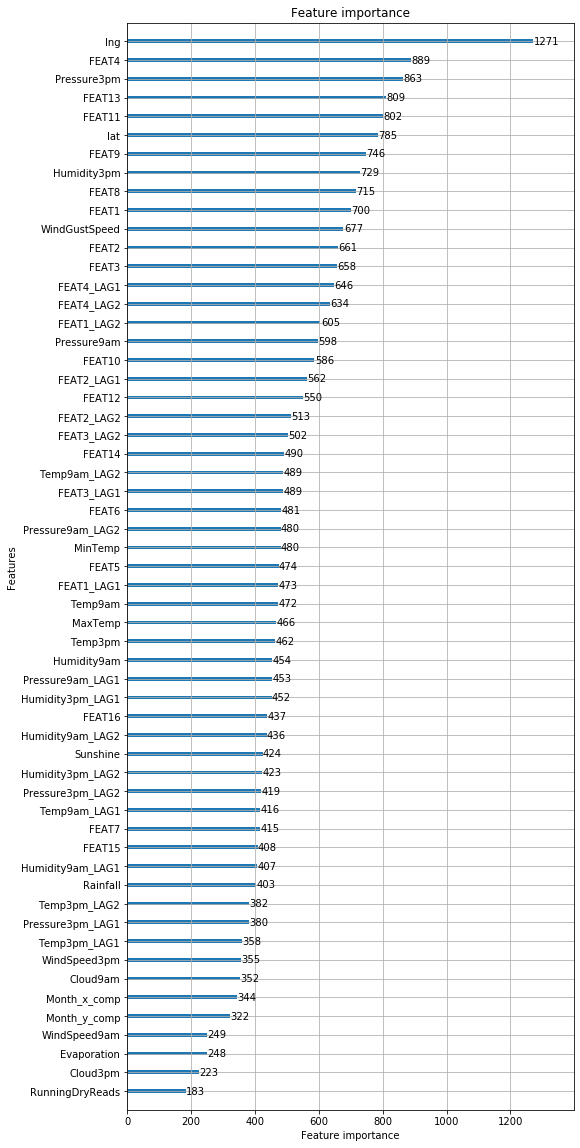

In [24]:
lgb.plot_importance(searcher.best_estimator_, figsize=(8, 20))

In [25]:
roc_auc_score(y_test, searcher.best_estimator_.predict(X_test.drop(columns=["Location"])))

0.7588492584900803